In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import math
import itertools
from typing import List, Union, Sequence


# Third-party library imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from numpy import ndarray
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from torch_geometric.data import Data
from torch_geometric.nn import ChebConv
from torch_geometric.nn.conv import GeneralConv

# Project-specific import
from Utils_GAN.classes import DynamicGraphTemporalSignal, GConvGRU, BoidDatasetLoader,RecurrentGCN
from Utils_GAN.classes import Encoder,Decoder,GraphSeqGenerator
from Utils_GAN.classes import GraphSeqDiscriminator,GraphSeqGenerator


from Utils_GAN.subfunctions import temporal_signal_split, train,plot_predictions,test,create_video_from_images
from Utils_GAN.subfunctions import train_generator,test_generator,test_generator_plot

### For Now: Grabbing Parts of Pytorch Geometric Temporal As Having Difficulty Setting Up The Environment For It

## Set Up BoidDatasetLoader To Load Entire Dataset
Following Example of EnglandCovidDatasetLoader from Pytorch Geometric Temporal

In [2]:
# reset kernel if not working
loader = BoidDatasetLoader()
dataset = loader.get_dataset()
dataset.snapshot_count

9999

In [3]:
loader.min_features[0:2], loader.max_features[0:2]

(array([ 0.77037874, 10.09544699]), array([997.09113397, 990.39823977]))

# Split Dataset Into Training and Testing

In [4]:
train_dataset, test_dataset = temporal_signal_split(dataset)

train_dataset.snapshot_count, test_dataset.snapshot_count

(7999, 2000)

## Create GConvGRU For Recurrent Layer In Our GNN

## Basic Graph Recurrent Neural Network

In [5]:
#  Training a basic model for tesiting purpose
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(3):
    for seq_start in tqdm(range(0, train_dataset.snapshot_count - 5, 5)):
        h_t_prev = None
        for i in range(5):
            snapshot = train_dataset[seq_start+i]
            y_hat, h_t = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_t_prev)
            h_t_prev = h_t
        cost = F.mse_loss(y_hat, snapshot.y)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()


  6%|▌         | 96/1599 [00:05<01:30, 16.61it/s]


KeyboardInterrupt: 

## Training

In [6]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(train_dataset, 10, model, optimizer)

Epoch: 1/10


Training:   0%|          | 39/7991 [00:03<11:42, 11.32it/s]


KeyboardInterrupt: 

  1%|          | 11/1992 [00:04<12:50,  2.57it/s]


KeyboardInterrupt: 

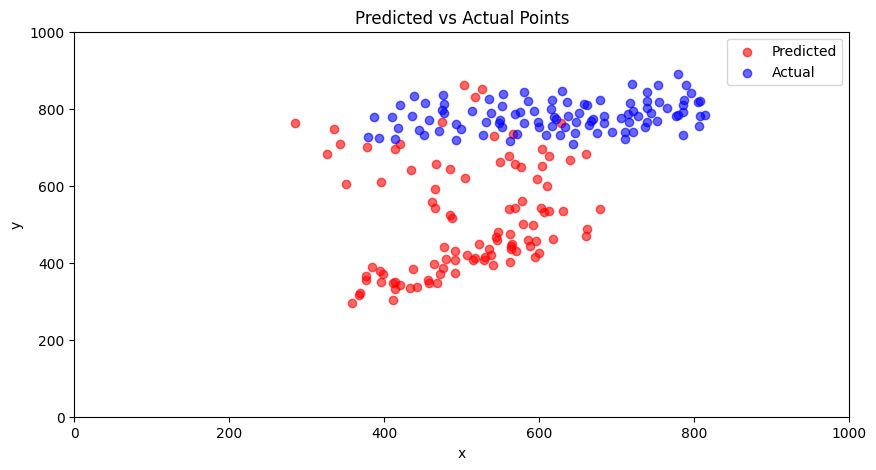

In [7]:
test(test_dataset, model,loader=loader)

In [8]:
import cv2
import os
import re

# Example usage
create_video_from_images('../generator_test_plots_at_epoch_30', 'generator_test_plots_at_epoch_30.mp4', fps=30)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../generator_test_plots_at_epoch_30'

## Working on GAN [Generator: (Encoder, Decoder)] [Discriminator: (Encoder)]

In [9]:
generator = generator = GraphSeqGenerator(node_feat_dim=4,
                              enc_hidden_dim=32,
                              enc_latent_dim=16,
                              dec_hidden_dim=32,
                              pred_horizon=8,
                              min_max_x=(loader.min_features[0], loader.max_features[0]),
                              min_max_y=(loader.min_features[1], loader.max_features[1]),
                              min_max_edge_weight=(loader.min_edge_weight, loader.max_edge_weight),
                              visualRange=75,
                            )

device = torch.device('cpu')

generator.to(device)

GraphSeqGenerator(
  (encoder): Encoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [10]:
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

train_generator(train_dataset, 10, generator, optimizer, horizon=generator.out_steps)

Epoch: 1/10


Training:   0%|          | 7/7984 [00:03<1:09:32,  1.91it/s]


KeyboardInterrupt: 

In [11]:
test_generator(test_dataset, generator, horizon=generator.out_steps)

Testing:   1%|          | 24/1985 [00:08<11:20,  2.88it/s]


KeyboardInterrupt: 

Testing:   0%|          | 0/1985 [00:00<?, ?it/s]

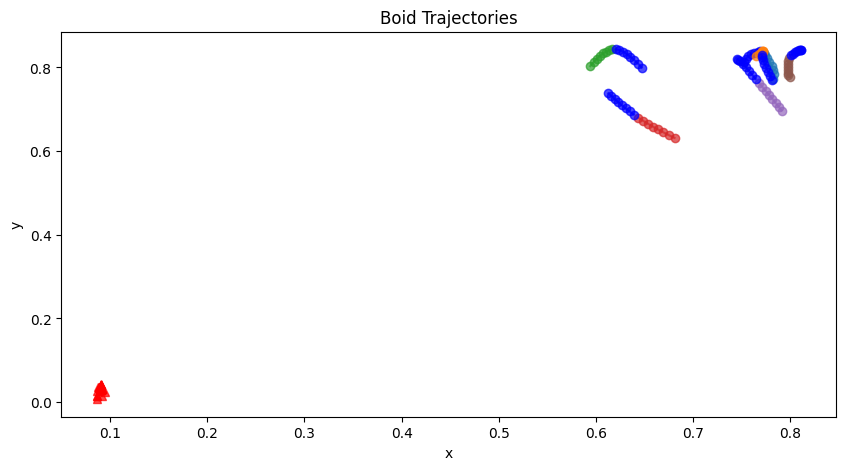

Testing:   0%|          | 1/1985 [00:00<19:43,  1.68it/s]

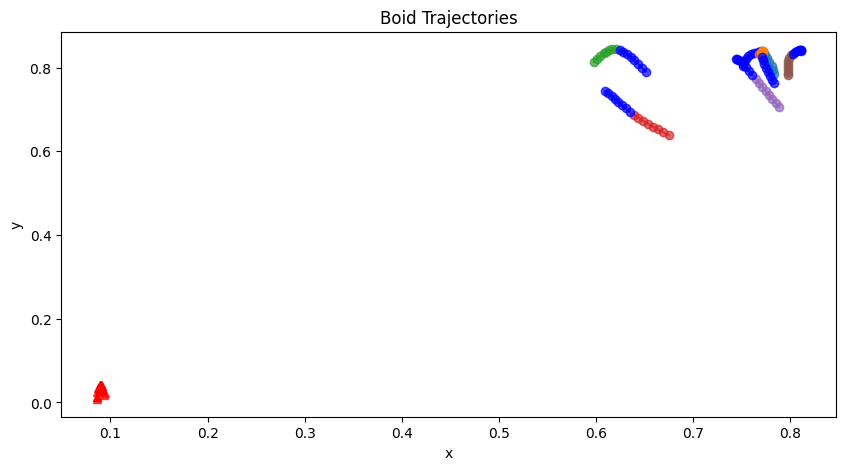

Testing:   0%|          | 2/1985 [00:01<19:18,  1.71it/s]

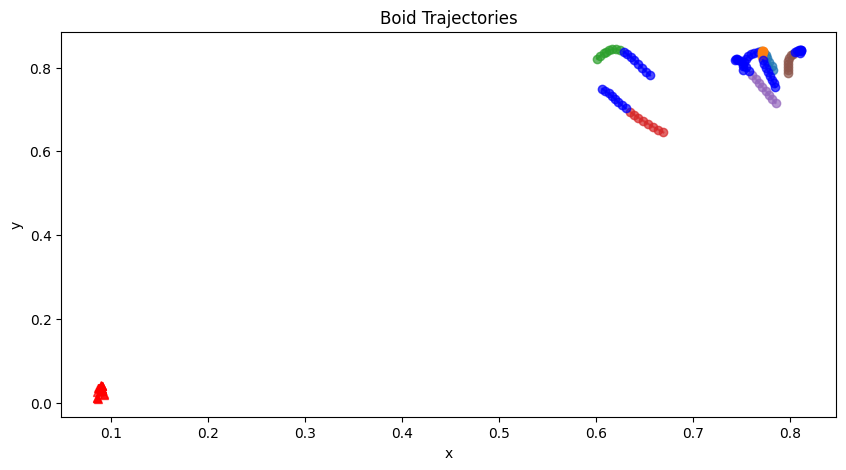

Testing:   0%|          | 3/1985 [00:01<19:34,  1.69it/s]

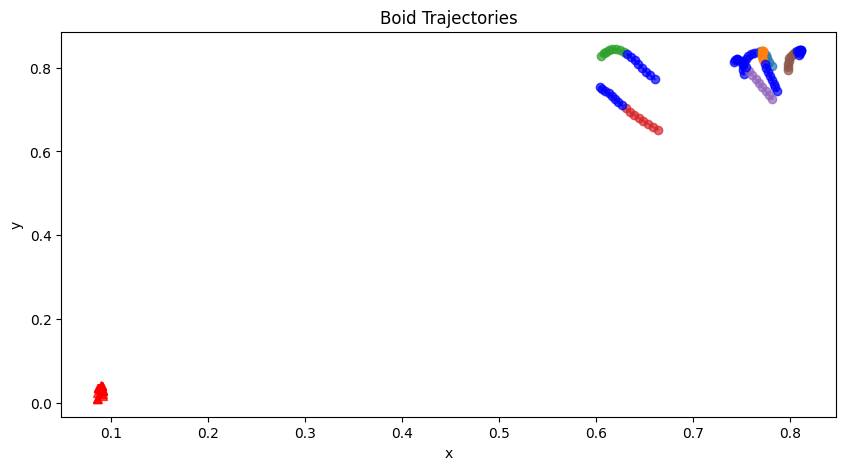

Testing:   0%|          | 4/1985 [00:02<19:21,  1.71it/s]

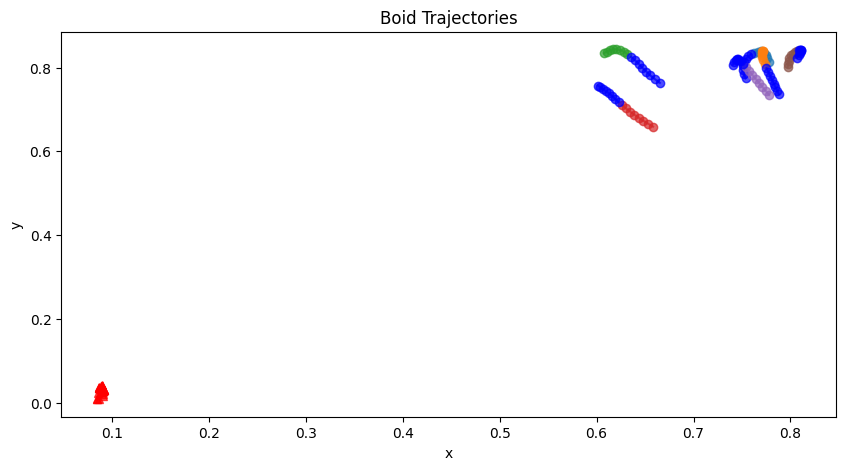

Testing:   0%|          | 5/1985 [00:02<19:20,  1.71it/s]

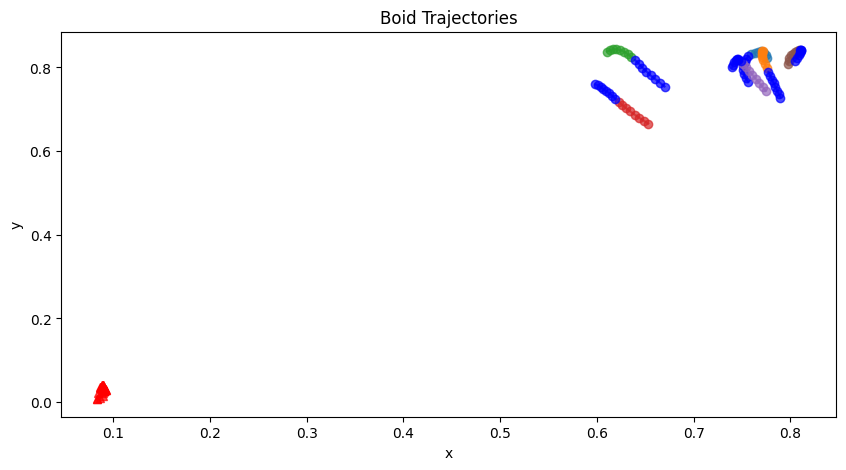

Testing:   0%|          | 6/1985 [00:03<19:07,  1.72it/s]

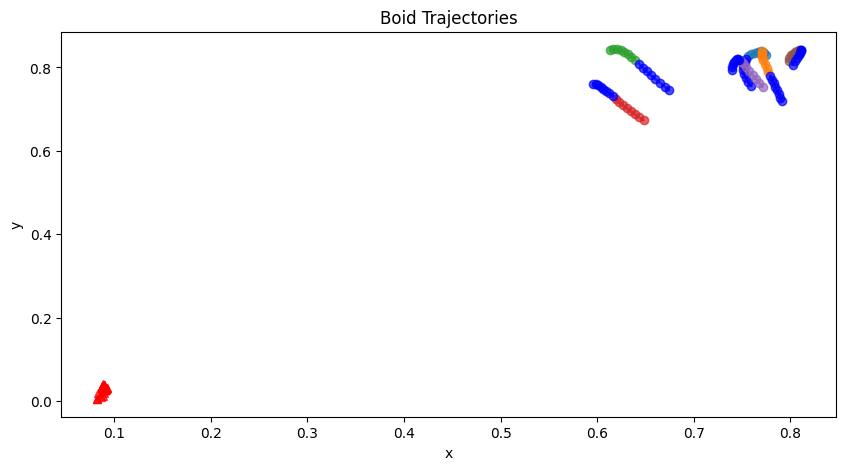

Testing:   0%|          | 7/1985 [00:04<21:41,  1.52it/s]


KeyboardInterrupt: 

In [12]:
test_generator_plot(test_dataset, generator, horizon=generator.out_steps)